# Introduction

Problem of binary classification

### Imports

In [249]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = None
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import matplotlib.pyplot as plt
import itertools


### Reformat Excel to csv


In [378]:
import pandas as pd
import csv


def format_excel_to_csv(filename: str) -> pd.DataFrame:
    """If excel is not readable with pandas because of comma separator,
    this function reformat and convert to a csv file.
    
    """
    
    # Excel file to reformat
    xl = pd.read_excel(filename, header=None)
    xl['splitted'] = xl[0].str.split(',')
    
    # Nex dataframe formated
    df = pd.DataFrame()
    for i, elmt in enumerate(xl['splitted'][0]):
        df[elmt] = xl[1:]['splitted'].apply(lambda x: x[i])
        
    df = df.reset_index(drop=True)
    df.to_csv('src/datasets/credit.csv', index=False, encoding='utf-8', sep=',')
    return 

format_excel_to_csv('src/datasets/credit.xlsx')


In [379]:
df = pd.read_csv('src/datasets/credit.csv', sep=',', encoding='utf-8')

In [380]:
print('shape', df.shape)

shape (1000, 21)


In [381]:
df.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_length,installment_rate,personal_status,other_debtors,residence_history,property,age,installment_plan,housing,existing_credits,default,dependents,telephone,foreign_worker,job
0,< 0 DM,6,critical,radio/tv,1169,unknown,> 7 yrs,4,single male,none,4,real estate,67,none,own,2,1,1,yes,yes,skilled employee
1,1 - 200 DM,48,repaid,radio/tv,5951,< 100 DM,1 - 4 yrs,2,female,none,2,real estate,22,none,own,1,2,1,none,yes,skilled employee
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 yrs,2,single male,none,3,real estate,49,none,own,1,1,2,none,yes,unskilled resident
3,< 0 DM,42,repaid,furniture,7882,< 100 DM,4 - 7 yrs,2,single male,guarantor,4,building society savings,45,none,for free,1,1,2,none,yes,skilled employee
4,< 0 DM,24,delayed,car (new),4870,< 100 DM,1 - 4 yrs,3,single male,none,4,unknown/none,53,none,for free,2,2,2,none,yes,skilled employee


# Constant

In [404]:
FEATURES = [
    "checking_balance",
    "months_loan_duration",
    "credit_history",
    "purpose",
    "amount",
    "savings_balance",
    "employment_length",
    "installment_rate",
    "personal_status",
    "other_debtors",
    "residence_history",
    "property",
    "age",
    "installment_plan",
    "housing",
    "existing_credits",
    "dependents",
    "telephone",
    "foreign_worker",
    "job",   
]

TARGET = ['default']

In [417]:
df.purpose

0        radio/tv
1        radio/tv
2       education
3       furniture
4       car (new)
          ...    
995     furniture
996    car (used)
997      radio/tv
998      radio/tv
999    car (used)
Name: purpose, Length: 1000, dtype: object

In [405]:
df['default'].value_counts()

1    700
2    300
Name: default, dtype: int64

# Split df to X and y

In [406]:
X = df[FEATURES]
y = df[TARGET]

In [407]:
print('df shape : ', df.shape)
print('X shape : ', X.shape)
print('y shape : ', y.shape)

df shape :  (1000, 21)
X shape :  (1000, 20)
y shape :  (1000, 1)


In [410]:
pd.Series(y[TARGET].values.ravel())

0      1
1      2
2      1
3      1
4      2
      ..
995    1
996    1
997    1
998    2
999    1
Length: 1000, dtype: int64

### Prpeprocessing

#### Categrorical variables

In [185]:
# OBJECT FEATURES
obj_list_to_one_hot_encode =  list(X.select_dtypes(include=['object']).columns)
print(obj_list_to_one_hot_encode)

['checking_balance', 'credit_history', 'purpose', 'savings_balance', 'employment_length', 'personal_status', 'other_debtors', 'property', 'installment_plan', 'housing', 'telephone', 'foreign_worker', 'job']


In [186]:
for col in obj_list_to_one_hot_encode:
    X[col] = X[col].astype('category')

/Users/anhnguyen/Desktop/test technique fairmoney/flask/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Numerical variables

In [140]:
# Numerical FEATURES
numerical_features = X.select_dtypes(exclude=['object']).columns
print(numerical_features)

Index(['checking_balance', 'months_loan_duration', 'credit_history', 'purpose',
       'amount', 'savings_balance', 'employment_length', 'installment_rate',
       'personal_status', 'other_debtors', 'residence_history', 'property',
       'age', 'installment_plan', 'housing', 'existing_credits', 'dependents',
       'telephone', 'foreign_worker', 'job'],
      dtype='object')


#### remap target

In [187]:
di = {1: 0, 2: 1}  # remap 1 -> 0 (good loan), 2 -> 1 (defaulting)
y = y.map(di)

In [188]:
y.value_counts()

0    700
1    300
Name: default, dtype: int64

# Model

In [342]:
from sklearn.model_selection import train_test_split
from src.visualisation.cust_plot import plot_confusion_matrix
from src.metrics.cust_metric import find_optimal_cutoff, get_auc_score, get_accuracy_score

In [243]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

In [244]:
X_train.shape
X_test.shape

(800, 20)

(200, 20)

In [252]:
y_train.value_counts()/len(y_train)*100

0    70.0
1    30.0
Name: default, dtype: float64

In [253]:
y_test.value_counts()/len(y_test)*100

0    70.0
1    30.0
Name: default, dtype: float64

# Lightgbm

In [245]:
import lightgbm as lgb

In [305]:
train_data = lgb.Dataset(data=X_train, label=y_train, weight=10**y_train)
test_data = lgb.Dataset(data=X_test, label=y_test)

In [306]:
params = {
'application': 'binary',
'objective': 'binary',
'metric': 'auc',
'is_unbalance': 'true',
'boosting': 'gbdt',
'num_leaves': 8,
'feature_fraction': 0.8,
'bagging_fraction': 0.8,
'bagging_freq': 20,
'is_unbalance': 'true',
'learning_rate': 0.001,
'verbose': 0,
    'max_depth': 5
}
    

# lgbm = lgb.train(param, ltr, num_boost_round=1000, valid_sets=[(ltr)], verbose_eval=100)


lgbm = lgb.train(
                params,
                train_data,
                valid_sets=test_data,
                num_boost_round=1500,
                verbose_eval=10,
                early_stopping_rounds=150,
                )

Training until validation scores don't improve for 150 rounds
[10]	valid_0's auc: 0.743452
[20]	valid_0's auc: 0.741012
[30]	valid_0's auc: 0.746131
[40]	valid_0's auc: 0.746131
[50]	valid_0's auc: 0.757798
[60]	valid_0's auc: 0.760536
[70]	valid_0's auc: 0.763036
[80]	valid_0's auc: 0.766845
[90]	valid_0's auc: 0.765595
[100]	valid_0's auc: 0.769286
[110]	valid_0's auc: 0.773631
[120]	valid_0's auc: 0.77494
[130]	valid_0's auc: 0.773155
[140]	valid_0's auc: 0.768512
[150]	valid_0's auc: 0.767083
[160]	valid_0's auc: 0.766369
[170]	valid_0's auc: 0.765536
[180]	valid_0's auc: 0.764226
[190]	valid_0's auc: 0.763869
[200]	valid_0's auc: 0.770952
[210]	valid_0's auc: 0.772738
[220]	valid_0's auc: 0.772917
[230]	valid_0's auc: 0.77256
[240]	valid_0's auc: 0.771964
[250]	valid_0's auc: 0.77256
[260]	valid_0's auc: 0.771369
Early stopping, best iteration is:
[119]	valid_0's auc: 0.77494


# XGBOOST

# Results for Lightgbm
Show graphs and stats here

In [307]:
pred = lgbm.predict(X_test)
print('roc auc lightgbm : ', get_auc_score(y_test, pred))


roc auc lightgbm :  0.7749404761904762


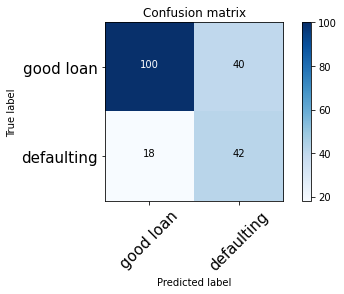

In [308]:

threshold = find_optimal_cutoff(y_test, pred)
pred_opt = (pred > threshold).astype(int) # Find prediction to the dataframe applying threshold

plot_confusion_matrix(y_test, pred_opt, classes=['good loan', 'defaulting'])

# optim bayesienne with lightgbm

In [346]:
from bayes_opt import BayesianOptimization


train_data = lgb.Dataset(data=X_train, label=y_train, weight=10**y_train)
test_data = lgb.Dataset(data=X_test, label=y_test)

def lgb_evaluate(num_leaves, feature_fraction, bagging_fraction, bagging_freq, max_depth):
    
    params = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': int(num_leaves),
    'feature_fraction': feature_fraction,
    'bagging_fraction': bagging_fraction,
    'bagging_freq': int(bagging_freq),
    'is_unbalance': 'true',
    'learning_rate': 0.001,
    'max_depth': int(max_depth)
    }
    
  
    cv_result = lgb.cv(
            params,
            train_data,
            num_boost_round=150,
            nfold=5,
            metrics='auc',
            early_stopping_rounds=30,
            )
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE

    return np.array(cv_result['auc-mean']).max()


# Parameters for optimization

params = {
    'num_leaves': (2, 10),
    'feature_fraction': (0.6, 1.0),
    'bagging_fraction': (0.6, 1.0),
    'bagging_freq': (5, 10),
    "max_depth": (2, 8),
}

xgb_bo = BayesianOptimization(lgb_evaluate, params)
# Use the expected improvement acquisition function to handle negative numbers
# Optimally needs quite a few more initiation points and number of iterations
xgb_bo.maximize(init_points=10, n_iter=50, acq='ei')

|   iter    |  target   | baggin... | baggin... | featur... | max_depth | num_le... |
-------------------------------------------------------------------------------------
|  1        |  0.7539   |  0.6106   |  5.44     |  0.8185   |  3.336    |  5.374    |
|  2        |  0.7431   |  0.7836   |  6.852    |  0.9558   |  5.712    |  6.407    |
|  3        |  0.753    |  0.6605   |  6.5      |  0.7404   |  2.981    |  2.522    |
|  4        |  0.7529   |  0.9127   |  9.137    |  0.6015   |  3.595    |  2.29     |
|  5        |  0.7473   |  0.7865   |  9.169    |  0.792    |  6.374    |  5.556    |
|  6        |  0.7531   |  0.8744   |  8.893    |  0.6626   |  5.279    |  2.743    |
|  7        |  0.7586   |  0.9311   |  6.792    |  0.9123   |  4.709    |  8.173    |
|  8        |  0.6846   |  0.8649   |  6.953    |  0.9989   |  6.391    |  3.627    |
|  9        |  0.7477   |  0.8433   |  5.258    |  0.8634   |  6.306    |  5.808    |
|  10       |  0.7497   |  0.6684   |  7.787    |  0.8

In [347]:
xgb_bo.max


{'target': 0.7723772321428571,
 'params': {'bagging_fraction': 0.6,
  'bagging_freq': 5.0,
  'feature_fraction': 0.6,
  'max_depth': 5.584379841141617,
  'num_leaves': 8.214311114230881}}

In [348]:
p = xgb_bo.max['params']

In [349]:
params = {
'application': 'binary',
'objective': 'binary',
'metric': 'binary_logloss',
'is_unbalance': 'true',
'boosting': 'gbdt',
'num_leaves': int(p['num_leaves']),
'feature_fraction': p['feature_fraction'],
'bagging_fraction': p['bagging_fraction'],
'bagging_freq': int(p['bagging_freq']),
'is_unbalance': 'true',
'learning_rate': 0.001,
'max_depth': int(p['max_depth'])
}
print(params)

{'application': 'binary', 'objective': 'binary', 'metric': 'binary_logloss', 'is_unbalance': 'true', 'boosting': 'gbdt', 'num_leaves': 8, 'feature_fraction': 0.6, 'bagging_fraction': 0.6, 'bagging_freq': 5, 'learning_rate': 0.001, 'max_depth': 5}


In [411]:
optimize_model = lgb.train(
                params,
                train_data,
                verbose_eval=10,
                )


In [351]:
optim_pred = optimize_model.predict(X_test)

print('roc auc lightgbm : ', get_auc_score(y_test, optim_pred))



roc auc lightgbm :  0.7746428571428571


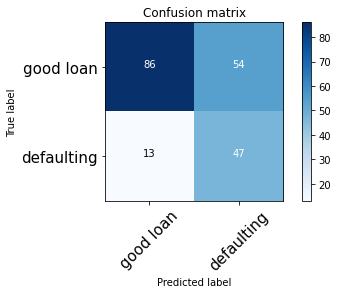

In [352]:

threshold = find_optimal_cutoff(y_test, optim_pred)
pred_opt = (pred > threshold).astype(int) # Find prediction to the dataframe applying threshold

plot_confusion_matrix(y_test, pred_opt, classes=['good loan', 'defaulting'])

In [353]:
get_accuracy_score(y_test, pred_opt)

0.665

Logistic: f1=0.584 auc=0.548


Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

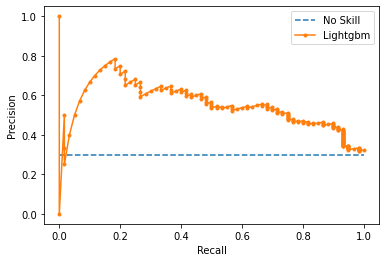

In [355]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot


lr_precision, lr_recall, _ = precision_recall_curve(y_test, optim_pred)

lr_f1, lr_auc = f1_score(y_test, pred_opt), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Lightgbm')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

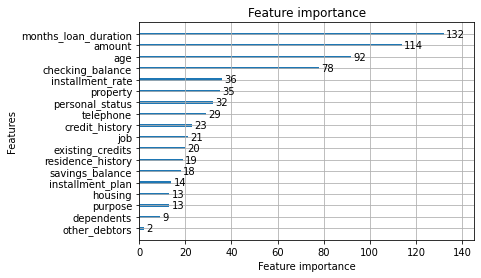

In [356]:
lgb.plot_importance(optimize_model, max_num_features=21, importance_type='split')

# Conclusions and Next Steps
Summarize findings here

In [357]:
import datetime

In [426]:
import time
timestr = time.strftime("%Y_%m_%d_%H_%M_%S")
print (timestr)

2020_05_05_22_22_09


In [370]:
tab = [
    'preprocessing_target_pipeline_output_v0.0.1-20200505164451-.pkl',
    'preprocessing_target_pipeline_output_v0.0.1-20200505164406-.pkl'
    
]

In [377]:
max([e.split('-')[1] for e in tab])

'20200505164451'

In [427]:

from datetime import datetime

# current date and time
now = datetime.now()

timestamp = datetime.timestamp(now)
print("timestamp =", timestamp)

timestamp = 1588710173.361063


In [430]:

from datetime import datetime

# current date and time
now = datetime.now()

timestamp = datetime.timestamp(now)
print("timestamp =", timestamp)

timestamp = 1588710236.62522


In [431]:

from datetime import datetime


dt_object = datetime.fromtimestamp(timestamp)

print("dt_object =", dt_object)
print("type(dt_object) =", type(dt_object))

dt_object = 2020-05-05 22:23:56.625220
type(dt_object) = <class 'datetime.datetime'>
